In [0]:
!pip install -q keras-bert
!wget -q https://storage.googleapis.com/bert_models/2018_11_03/chinese_L-12_H-768_A-12.zip
!unzip -o chinese_L-12_H-768_A-12.zip

Archive:  chinese_L-12_H-768_A-12.zip
   creating: chinese_L-12_H-768_A-12/
  inflating: chinese_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: chinese_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: chinese_L-12_H-768_A-12/vocab.txt  
  inflating: chinese_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: chinese_L-12_H-768_A-12/bert_config.json  


藉由bert模型產生的句子向量來做文本摘要，屬於抽取式摘要，將句子轉成向量後，做clustering 

做完clustering 之後找出離質心最近的點，以該點為抽取出來的句子。 


In [0]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras_bert import Tokenizer, load_trained_model_from_checkpoint
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
class Bert_extractive():
    def __init__(self, text, summary_num, reduct_dim, see= False, seqence_len=150):    
        self.text = text
        self.summary_num = summary_num
        self.seqence_len = seqence_len
        self.see = see
        self.reduct_dim = reduct_dim

    def get_model(self):
        pretrained_path = 'chinese_L-12_H-768_A-12'
        config_path = os.path.join(pretrained_path, 'bert_config.json')
        checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
        vocab_path = os.path.join(pretrained_path, 'vocab.txt')
        self.token_dict = {}
        with open(vocab_path, 'r', encoding='utf8') as f:
            for line in f.readlines():
                token = line.strip()
                self.token_dict[token] = len(self.token_dict)

        model = load_trained_model_from_checkpoint(
            config_path,
            checkpoint_path,
            training=False,
            trainable=False,
            seq_len=self.seqence_len,
            )
        self.mine = Model(model.input[:2],outputs = model.get_layer('Encoder-11-FeedForward-Norm').output)
    
    def article_preprocess(self):
        tokenizer = Tokenizer(self.token_dict)
        self.text_split = [ele for ele in self.text.split('。') if len(ele) > 0]
        self.sent_num = len(self.text_split)
        tok = [tokenizer.encode(sent)[0] for sent in self.text_split]
        tok_pad = pad_sequences(tok, maxlen=self.seqence_len)
        self.data_in = [tok_pad, np.zeros(shape=(self.sent_num, self.seqence_len))]


    def turn_vector_pca(self):
        ans = self.mine.predict(self.data_in)
        avg_tok = np.array([sum(ans[x][:]/ans.shape[2]) for x in range(self.sent_num)])
        pca = PCA(n_components=self.reduct_dim)
        pca.fit(avg_tok)
        self.X_embedded = PCA(n_components=self.reduct_dim).fit_transform(avg_tok)
        if (self.see == True) & (self.reduct_dim==2):
            print(pca.explained_variance_ratio_)
            print(self.X_embedded.shape)
            plt.scatter(self.X_embedded[:,0],self.X_embedded[:,1])
            count = 0
            for a, b in self.X_embedded:
                plt.annotate('(%s)' %(count),
                    xy=(a, b),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='top')
                count += 1
            plt.show()

    # 做完clustering 之後找出離質心最近的點，以該點為抽取出來的句子。
    def clustering(self):
        self.X_embedded = preprocessing.scale(self.X_embedded)
        self.k_means = KMeans(init='k-means++', 
                              n_clusters=self.summary_num, 
                              n_init=10, 
                              max_iter = 600)
        self.k_means.fit(self.X_embedded)
        self.y_predict = self.k_means.predict(self.X_embedded)

        if (self.see == True) & ((self.reduct_dim==2)):
            plt.scatter(self.X_embedded[:,0],
                        self.X_embedded[:,1], 
                        c=self.y_predict)
            plt.scatter(self.k_means.cluster_centers_[:,0], 
                        self.k_means.cluster_centers_[:,1], 
                        marker = '*', 
                        s = 150, 
                        c='r')
            count = 0
            for a, b in self.X_embedded:
                plt.annotate(
                    '(%s)' %(count),
                    xy=(a, b),
                    xytext=(0, 15),
                    textcoords='offset points',
                    ha='center',
                    va='top')
                count += 1
            plt.show()

    def find_point(self):
        X = self.X_embedded
        y = self.y_predict
        center = self.k_means.cluster_centers_
        def distance(a,b):
            res = [(a[n]-b[n])**2  for n in range(len(a))]
            return np.sqrt(sum(res))

        output = []
        for gp in np.unique(y):
            idx_list = np.where(self.y_predict==gp)[0]
            dist_list = [distance(center[gp],X[idx]) for idx in idx_list]
            pos = np.argmin(dist_list)
            output.append(idx_list[pos])
        self.output = output

    def make_summary(self):
        self.get_model()
        self.article_preprocess()
        self.turn_vector_pca()
        self.clustering()
        self.find_point()
        summary = '。'.join([self.text_split[x] for x in self.output]) + '。'
        return summary

使用方式：
1. text : 放入單篇文章
2. summary_num: 文章要幾句
3. reduce_dim: 預設為2，只有壓縮到二維的時候才能打在圖上，使用時直接設成2就好
4. see：預設為 False，決定要看不要看圖片，單純摘要就不需要設定此項
5. seqence_len : 句子進去的最大長度，預設150


[0.40019968 0.09767049]
(45, 2)


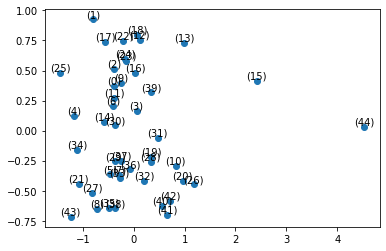

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


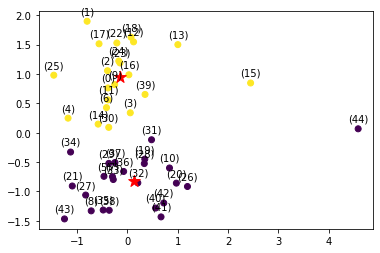

' \n    耀才證券研究部總監植耀輝指出，港股外圍走勢受壓，反映中美貿戰的關稅問題再度困擾市場；加上疫情持續對經濟帶來的影響，增添不明朗因素。香港股市今(22)日上午9點半以大跌500點開出後，跌勢一路擴大，一度重挫超過900點。'

In [0]:
Bert_extractive(
    # text, 
    '''
    美股昨日受挫，牽動投資人信心，周五香港恆生指數開盤走跌，初盤跌幅擴大至750點或-3%，為23529點。
    國企股(H股)跌229點或-2.2%%，為9620點。綜合企業類跌3.5%，半導體類跌3.2%，銀行類跌3%，為跌幅最大的板塊。
    香港本地股出現集體下跌情形，周大幅和莎莎國際暴跌5%，九龍倉置業跌7%，新世界發展跌6.5%，恆隆地產跌5.1%，六福集團跌超6%。康希諾生物接續昨日跌勢，開盤大跌超過5%。
    康希諾生物公告指出，該公司近日股價波動，知會股東，該公司營運正常，不知悉價格波動確切原因。
    醫藥相關個股開盤皆呈下跌趨勢，歌禮製藥跌超過5%，脈搏製藥與信達生物皆跌約4%。據悉除了疫苗開發受挫傳聞之外，疫苗開發失敗例子甚多，製藥個股至今上漲已多，在公司仍未有盈餘下，投資人獲利回吐。
    中共人大開議，宣告將制定「香港國安法」，衝擊一國兩制信心。香港股市今(22)日上午9點半以大跌500點開出後，跌勢一路擴大，一度重挫超過900點。
    憂心香港國安法上路後，可能威脅香港自由港以及金融中心地位，香港恆生指數今天以下跌523點開出，上午10點半左右，一度重挫超過900點，跌幅達3.7%，又以本地地產股跌幅最重。
    至於台北股市，今日以下跌30.76點開出，隨後跌幅擴大，早盤下挫超過百點，10900點得而復失。港股午後跌幅擴大至逾千點，死守23,600水平，全日數到23,613點，挫1,029點；H指跌441點，報9,599點；成交1,096億元。 
    紐約期油曾跌約7%至18美元一桶，惟三桶油業績失色，中石油（857）跌8.6%，報2.55元；中石化（386）跌8.42%，報3.59元；中海油（883）跌7.17%，報8.16元。
    其中中石油今年第一季盈轉虧蝕162.3億元人民幣；中石化盈轉虧蝕197.82億元人民幣。 
    相關新聞：【全球救市．不斷更新】恒指全日彈254點 3175升一成 一個月拆息兩年低 專家：上落市多於單邊大跌（附互動圖片） 
    疫情令澳門封關，4月澳門博彩收入重挫97%至7.54億澳門元，為2002年賭權開放後最差月份
    濠賭股全線回落，金沙（1928）跌4.7%，報30.4元；銀娛（27）跌3.47%至 48.7元；新濠（200）跌7.26%，報13.54元；美高梅（2282）跌6.91%，報90.3元。 ATM無一倖免，騰訊（700）跌4.08%，報400元
    阿里（9988）跌3.71%，報189.7元；美團（3690）跌2.99%，100.7元。 滙控（5）再跌穿40元關口，報38.6元，跌4.1%。 【中午12時】 
    港股今早低開後不斷尋底，半日跌947點，報23,696點；H指跌426點，報9,613點；主板成交634億元。 
    正榮金融業務部副總裁郭家耀表示，由於上周五環球股市普遍向下，恒指受外圍因素影響而大跌市，加上早前升勢較強，不少投資者此期間選擇獲利回吐。
    另外，中美關係漸趨緊張亦直接影響市況，他認為5月中市場前未必有利好消息，恒指將徘徊在23,000點，但由於市場對疫情已有相當的把握，他指投資者不可能再劈價出貨，所以港股不會再試3月的低位。
    而在重磅藍籌股、科網股及物管股調整期間，散戶可考慮撈貨。 【上午11時】 港股跌幅繼續擴大，現跌914點，報23,728點；H指跌421點，報9,619點；主板成交530億元。 
    港股低開700餘點後，跌幅迅速擴大至864點，恒指最新報23,779點；H指跌377點，報9,663點；主板成交140億元。
    踏入「五窮月」，港股今早低開748點，報23,895點；H指低開325點，報9,716點。道指期貨現跌300點。
    專欄作家魏力表示，外圍好消息盡出，鮑威爾明言「經濟W形復蘇也是過於樂觀」，一盆冷水照頭淋，好友清醒過後轉趨避險，操作上至起碼食糊獲利，並增加現金及對冲比重，近日狂炒的物管、教育股，小心成為大戶減磅對象。 
    他又指，恒指預期大低開之下，可冷吼早前受疫情重創的旅遊相關股。
    五一長假首兩天，大陸出遊人次達5,000萬，約為去年同期一半，多個著名景點達到接待人數上限，較市場預期為佳，可望為股價低殘的驢跡科技（1745）帶來沖喜。 
    驢跡是中國最大的在線電子導覽提供商，今年1月17日掛牌，上市價2.12元，甫上市就遇上武漢肺炎，現價潛水57%。
    公司上周三出通告，主席臧偉仲以均價0.888元增持74.6萬股，為上市以來首次，應有一定指標意義。
    走勢上，3月中以來，驢跡一直在0.8元水平橫行整固，近日成交漸增，有條件借勢開車，短線可於0.88至0.9元買入，上方阻力1.09元，失守0.8元止蝕。 
    耀才證券研究部總監植耀輝指出，港股外圍走勢受壓，反映中美貿戰的關稅問題再度困擾市場；加上疫情持續對經濟帶來的影響，增添不明朗因素。港股缺乏北水支持，不排除恒指會跌穿23500點水平；
    加上內地復工後或有第二波疫情擴散，港股料繼續受壓。 【上午7時30分】 四日長假後，迎接5月第一個交易日。不論是港股傳統智慧「五窮六絕」，抑或西方「Sell in May and go away」，都一脈相承地為5月股市落魔咒。 
    往績計，過去10年，當中8年的5月，埋單均錄跌，相當於應驗率高達八成；以廿年數據統計，5月跌市命中率亦達七成。
    不過，參考03年，沙士疫情於夏天後逐漸減退，而港股亦打破跌市厄運，於5月急彈8.8%，並展開長達四年的大升浪。 
    至於武漢肺炎疫情下，港股、以至環球股市，能否打破宿命仍有待分曉，但可以肯的是，5月開局，未出閘，先脫腳。周五港股ADR指數，已較假期前收市大幅低水逾千點；
    至於恒指黑期同樣戰況慘烈，至上午7時25分，港股黑期報23,756點，較上周三收市低水888點。 
    事實上，雖然個別國家疫情有所紓緩，但市場憂慮一籮籮，除擔心再有新一波疫情爆發、企業業績、經濟數據慘不忍睹外，最重要是中美之間的政治角力，再度因疫情而升溫。
    美國總統特朗普近日開始放風，就美國爆發瘟疫追究中國責任，除再度威脅加徵關稅外；美國《華盛頓郵報》亦指，華府召開跨部門會議，決定對中國採取何種報復行動。 
    同時，油價低賤令產油國經濟陷入史詩式危機，沙地財政部部長稱，該國將推出嚴厲的經濟措施，如大幅削支以對抗經濟衝擊，但警告措施將會帶來「陣痛」，消息令沙地周日股市大跌逾7%。
    負面情況籠罩下，港股5月開局注定失利。
    ''',
    2, 2, True).make_summary()